In [1]:
import multiprocessing

num_processor = multiprocessing.cpu_count()
print("Number of processor:",num_processor)

Number of processor: 40


In [2]:
# Python Libraries
import re

import numpy as np
import pandas as pd
from datetime import datetime
import tqdm

# Gensim libraries
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy for lammatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 42

# ignore Warnings
import warnings
warnings.filterwarnings('ignore')

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

# Global Variable Setting
batch_size=100 
num_workers= (num_processor - 1 )

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
wiki_train_df = pd.read_csv('wiki_train_features_clean.csv',index_col=[0])
wiki_train_df.head()

,original_text_cleaned,dale_words_prcnt,aoa_words_prcnt,aoa_words_age_scaled,aoa_words_freq_scaled,aoa_words_syll_scaled,con_words_prcnt,con_known_prcnt_scaled,con_mean_count_scaled,con_subtlex_count_scaled,label
0,there is manuscript evidence that austen conti...,0.538462,0.743590,0.333767,0.239298,0.325581,0.743590,0.397884,0.349361,0.351382,1
1,in a remarkable comparative analysis mandaean ...,0.260870,0.608696,0.203983,0.123455,0.224806,0.608696,0.193930,0.167534,0.123463,1
2,before persephone was released to hermes who h...,0.604651,0.860465,0.382592,0.346244,0.410853,0.790698,0.469859,0.408546,0.337486,1
3,cogeneration plants are commonly found in dist...,0.303030,0.818182,0.353507,0.070608,0.372093,0.939394,0.429208,0.522348,0.077689,1
4,geneva lrb rrb is the second most populous cit...,0.468750,0.593750,0.206703,0.238458,0.217054,0.593750,0.260894,0.234528,0.238436,1


#### Tokenize words and Clean text

In [4]:
train_text = wiki_train_df.original_text_cleaned

def sentence_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sentence_to_words(train_text))

print(data_words[:1])

[['there', 'is', 'manuscript', 'evidence', 'that', 'austen', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'and', 'that', 'her', 'niece', 'and', 'nephew', 'anna', 'and', 'james', 'edward', 'austen', 'made', 'further', 'additions', 'as', 'late', 'as']]


#### Create Bigram Models

In [5]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

bigram_model = gensim.models.phrases.Phraser(bigram)

#### Remove Stopwords, Make Bigrams and Lemmatize

In [6]:
def remove_stopwords(texts):
    print("Removing Stopwords:",datetime.now())
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [7]:
def make_bigrams(texts):
    print("Checking Bigrams:",datetime.now())
    return [bigram_model[doc] for doc in texts]

In [8]:
def lemmatize_sentences(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

    lema_texts = []
#     below code can be used for parallelization after reconstructing sentences from tokens and 
#     passing list of sentences to this function
#     for doc in nlp.pipe(docs, batch_size=batch_size, n_process=num_workers, disable=["parser", "ner"]):
#         lema_texts.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    print("lamatizing sentences",datetime.now())   
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        lema_texts.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    print("Finished lamatizing sentences",datetime.now())

    return lema_texts

Uncomment code below to install spacy

In [9]:
# Download spacy for "en" model
# !python3 -m spacy download en

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Make Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# data_words_bigrams[:1]

# Initialize spacy, keeping only tagger components for efficiency
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatize_sentences(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# data_lemmatized
print(data_lemmatized[:1])

Removing Stopwords: 2022-10-19 14:27:56.467844
Checking Bigrams: 2022-10-19 14:28:22.704435
lamatizing sentences 2022-10-19 14:28:33.235556
Finished lamatizing sentences 2022-10-19 14:45:31.020456
[['evidence', 'continue', 'work', 'piece', 'late', 'period', 'make', 'addition', 'late']]


#### Create Dictionary & Corpus

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# remove rarest and most common words
id2word.filter_extremes(no_below=10, no_above=0.35)
id2word.compactify()

# Create Corpus
texts = data_lemmatized

# Create Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View Corpus
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [12]:
# check term frequency in corpus
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('continue', 1),
  ('evidence', 1),
  ('late', 2),
  ('make', 1),
  ('period', 1),
  ('piece', 1),
  ('work', 1)]]

#### Training LDA Model

We will use pre-trained saved model, uncomment the code to train the model again

In [13]:
# Build LDA Model : Use Multicore for efficiency

# Need to train once
# print("Training LDA Model:",datetime.now())
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     lda_train = models.ldamulticore.LdaMulticore(
#                            corpus=corpus,
#                            num_topics=20,
#                            id2word=id2word,
#                            chunksize=batch_size,
#                            workers=num_workers, # Num. Processing Cores - 1
#                            passes=50,
#                            eval_every = 1,
#                            per_word_topics=True)

#     print("Model Training Completed:",datetime.now())
#     #Save the model
#     lda_train.save('lda_train_v1.model')

In [14]:
# Once model is trained, load the trained model

lda_train = models.LdaMulticore.load('lda_train_v1.model')

In [15]:
# View topics in LDA : Top 10 topics and associated terms
for idx, topic in lda_train.print_topics(20,num_words=15)[:10]:
    print("Topic: {} \nWords: {}".format(idx, topic))

Topic: 0 
Words: 0.065*"state" + 0.058*"die" + 0.044*"build" + 0.034*"major" + 0.030*"run" + 0.026*"life" + 0.024*"kill" + 0.022*"rule" + 0.022*"important" + 0.016*"train" + 0.014*"divide" + 0.014*"tell" + 0.014*"new" + 0.013*"love" + 0.013*"female"
Topic: 1 
Words: 0.051*"go" + 0.045*"live" + 0.039*"music" + 0.038*"band" + 0.035*"show" + 0.035*"town" + 0.032*"government" + 0.031*"death" + 0.031*"good" + 0.026*"big" + 0.021*"person" + 0.019*"rock" + 0.018*"local" + 0.017*"lead" + 0.017*"try"
Topic: 2 
Words: 0.143*"name" + 0.048*"change" + 0.046*"movie" + 0.032*"found" + 0.031*"page" + 0.031*"appear" + 0.030*"feature" + 0.029*"character" + 0.028*"list" + 0.024*"original" + 0.024*"version" + 0.020*"originally" + 0.019*"sell" + 0.015*"director" + 0.014*"north"
Topic: 3 
Words: 0.097*"know" + 0.086*"first" + 0.043*"also" + 0.040*"well" + 0.033*"game" + 0.032*"release" + 0.031*"world" + 0.031*"start" + 0.026*"second" + 0.020*"american" + 0.018*"film" + 0.017*"television" + 0.017*"publish" 

In [16]:
# Compute Model Perplexity and Coherence Score
print('\nPerplexity: ', lda_train.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_train, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.09536567230502

Coherence Score:  0.3133692663561435


#### Hyperparameter Tuning

* Number of Topics (K) : finding appropriate K topics as per coherence score
* Use default values for other parameters : tuning to be done if time permits 

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    print("Compute Model Choerence Score:",datetime.now())
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics) 
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    print("Finished Computing Coherence Score:",datetime.now())
    
    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, limit=50, step=2)

Compute Model Choerence Score: 2022-10-19 14:46:47.360415
Finished Computing Coherence Score: 2022-10-19 14:52:10.546939


In [19]:
# Show graph
def show_graph(limit,start,step,coherence_values):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

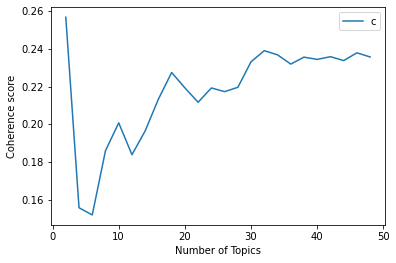

In [20]:
limit=50; start=2; step=2;
show_graph(limit,start,step,coherence_values)

In [21]:
x = range(start, limit, step)
# Print the coherence scores
topic_coh_dict = dict()
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    topic_coh_dict[m] = cv


Num Topics = 2  has Coherence Value of 0.2567
Num Topics = 4  has Coherence Value of 0.1558
Num Topics = 6  has Coherence Value of 0.152
Num Topics = 8  has Coherence Value of 0.1861
Num Topics = 10  has Coherence Value of 0.2008
Num Topics = 12  has Coherence Value of 0.1839
Num Topics = 14  has Coherence Value of 0.1965
Num Topics = 16  has Coherence Value of 0.2134
Num Topics = 18  has Coherence Value of 0.2274
Num Topics = 20  has Coherence Value of 0.2193
Num Topics = 22  has Coherence Value of 0.2117
Num Topics = 24  has Coherence Value of 0.2193
Num Topics = 26  has Coherence Value of 0.2173
Num Topics = 28  has Coherence Value of 0.2196
Num Topics = 30  has Coherence Value of 0.2331
Num Topics = 32  has Coherence Value of 0.239
Num Topics = 34  has Coherence Value of 0.2368
Num Topics = 36  has Coherence Value of 0.2319
Num Topics = 38  has Coherence Value of 0.2356
Num Topics = 40  has Coherence Value of 0.2344
Num Topics = 42  has Coherence Value of 0.2358
Num Topics = 44  ha

* The value of K optimum number of topics is not consistant, based on multiple ittereation of execution, it is found that K=20 is regionable number of topics where model has consistantly shown relatively high coherence value.

In [22]:
k = 20
print('value for K topics Index:',k)

optimal_model = model_list[k]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

value for K topics Index: 20
[(13, '0.011*"use" + 0.010*"line" + 0.009*"rrb" + 0.007*"number" + 0.007*"take" + 0.006*"become" + 0.006*"high" + 0.005*"first" + 0.005*"many" + 0.005*"bear"'), (17, '0.019*"name" + 0.016*"also" + 0.013*"first" + 0.013*"may" + 0.010*"use" + 0.008*"rrb" + 0.008*"team" + 0.005*"make" + 0.005*"system" + 0.005*"release"'), (37, '0.019*"also" + 0.017*"become" + 0.016*"release" + 0.011*"know" + 0.010*"game" + 0.009*"year" + 0.008*"make" + 0.007*"death" + 0.007*"play" + 0.006*"name"'), (9, '0.015*"time" + 0.011*"large" + 0.009*"population" + 0.008*"make" + 0.008*"also" + 0.008*"people" + 0.007*"move" + 0.007*"rrb" + 0.006*"city" + 0.006*"major"'), (26, '0.012*"bear" + 0.012*"may" + 0.010*"rrb" + 0.009*"first" + 0.009*"know" + 0.009*"football" + 0.008*"make" + 0.008*"player" + 0.007*"also" + 0.007*"date"'), (5, '0.018*"bear" + 0.013*"include" + 0.008*"music" + 0.007*"actress" + 0.007*"may" + 0.006*"american" + 0.006*"actor" + 0.006*"time" + 0.006*"film" + 0.005*"wr

#### Save Optimum Model

In [23]:
optimal_model.save('lda_train_v2.model')

# Load the trained model
# optimal_model = models.LdaMulticore.load('lda_train_v1.model')

#### Visualize the topics and terms

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
31     0.138443 -0.000686       1        1  3.723747
37     0.013903 -0.060584       2        1  3.294521
28    -0.061619  0.000522       3        1  2.746142
41    -0.034787 -0.010735       4        1  2.697646
9     -0.013643  0.008275       5        1  2.694240
34    -0.032217  0.025473       6        1  2.618419
39    -0.032102 -0.021164       7        1  2.555546
29    -0.031531  0.031635       8        1  2.552381
16    -0.006263 -0.058540       9        1  2.546324
22     0.006224 -0.015043      10        1  2.540294
23     0.008769  0.118596      11        1  2.523119
25    -0.047673 -0.010725      12        1  2.522689
10    -0.042802 -0.032351      13        1  2.486848
19     0.014162 -0.050099      14        1  2.441940
15     0.073300  0.009325      15        1  2.437254
27     0.001906 -0.036544      16        1  2.428576
30    -0.023291  0.009466      17        1  2.423466
8     -0.023137  0.017313      18        1  2.419841
2     -0.057156 -0.005213      19        1  2.411395
5      0.012212  0.009960      20        1  2.338830
33     0.020887  0.048844      21        1  2.310415
35    -0.010273  0.009381      22        1  2.287981
24    -0.010734 -0.009849      23        1  2.287484
38    -0.001565 -0.016636      24        1  2.277189
13    -0.019669  0.038756      25        1  2.269072
4      0.024567 -0.029581      26        1  2.268489
12     0.029204  0.036819      27        1  2.258444
18    -0.011382  0.003041      28        1  2.241340
21     0.027367 -0.011766      29        1  2.221773
20    -0.030094  0.010219      30        1  2.200474
17    -0.009309 -0.000865      31        1  2.179331
7      0.029503 -0.010582      32        1  2.171706
40    -0.014017 -0.035496      33        1  2.171247
14     0.056961 -0.015957      34        1  2.144850
6      0.043231 -0.006737      35        1  2.130864
36     0.013843 -0.004964      36        1  2.123342
32    -0.022017  0.008293      37        1  2.098233
3     -0.011228  0.064421      38        1  2.028185
26     0.033794  0.015380      39        1  2.027281
1     -0.010167 -0.028535      40        1  2.009777
11     0.013855  0.008660      41        1  1.992431
0     -0.005450 -0.001728      42        1  1.896876, topic_info=         Term          Freq         Total Category  logprob  loglift
457    region   6632.000000   6632.000000  Default  30.0000  30.0000
275      bear  16436.000000  16436.000000  Default  29.0000  29.0000
77   football   7292.000000   7292.000000  Default  28.0000  28.0000
31       find   7484.000000   7484.000000  Default  27.0000  27.0000
315    player   7518.000000   7518.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
436      form    140.822501   6958.709728  Topic42  -5.7404   0.0647
366       old    125.010069   4180.128630  Topic42  -5.8595   0.4553
140    become    135.679344  10400.419952  Topic42  -5.7776  -0.3743
278      name    131.249038  10562.178475  Topic42  -5.8108  -0.4230
537    number    127.091708   5800.687779  Topic42  -5.8430   0.1441

[3474 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
11774     28  0.193199  abbasid
11774     37  0.579596  abbasid
11774     40  0.128799  abbasid
13094      3  0.152226    abbey
13094     22  0.076113    abbey
...      ...       ...      ...
7460      31  0.030280     zinc
7460      39  0.010093     zinc
11820     28  0.099271   zombie
11820     31  0.099271   zombie
11820     39  0.794167   zombie

[31666 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[32, 38, 29, 42, 10, 35, 40, 30, 17, 23, 24, 26, 11, 20, 16, 28, 31, 9, 3, 6, 34, 36, 25, 39, 14, 5, 13, 19, 22, 21, 18, 8, 41, 15, 7, 37, 33, 4, 27, 2, 12, 1])

#### Find the Dominant topic in each setence

In [25]:
train_data = wiki_train_df.original_text_cleaned.tolist()

def find_sentence_topic(ldamodel=lda_train, corpus=corpus, texts=train_data):
    print("Find Setence Topic:",datetime.now())
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    print("Sentence topic identified:",datetime.now())
    return(sent_topics_df)

In [26]:
df_topic_sents_keywords = find_sentence_topic(ldamodel=optimal_model, corpus=corpus, texts=train_data)

Find Setence Topic: 2022-10-19 14:53:27.113654
Sentence topic identified: 2022-10-19 15:45:21.997683


In [27]:
df_topic_sents_keywords.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'text']

In [28]:
df_dominant_topic = df_topic_sents_keywords.copy()

In [29]:
# df_dominant_topic.index.name = 'Document_No'
df_dominant_topic = df_dominant_topic.rename_axis('Document_No').reset_index()
df_dominant_topic.head()

,Document_No,Dominant_Topic,Perc_Contribution,Topic_Keywords,text
0,0,2.0,0.9024,"name, use, award, rrb, form, know, year, call,...",there is manuscript evidence that austen conti...
1,1,0.0,0.6789,"know, include, first, long, time, play, well, ...",in a remarkable comparative analysis mandaean ...
2,2,30.0,0.5633,"last, name, die, rrb, use, year, area, great, ...",before persephone was released to hermes who h...
3,3,3.0,0.5405,"also, region, rrb, know, use, find, call, pica...",cogeneration plants are commonly found in dist...
4,4,11.0,0.8605,"second, large, may, locate, city, rrb, also, u...",geneva lrb rrb is the second most populous cit...


#### Combine LDA Topic Features with Main dataset used for Supervised Learning

In [30]:
df2 = wiki_train_df.copy()
# df2.index.rename('Document_No', inplace=True)
df2 = df2.reset_index()
print(df2.index.min(),df2.index.max())
df2.index.rename('Document_No', inplace=True)
df2 = df2.drop('index', axis=1)
df2 = df2.reset_index()

0 416591


In [31]:
print('No of records in df_dominant_topic:',df_dominant_topic.shape[0])
print('No of records in wiki_train_df:',df2.shape[0])
df_feature_LDA_dataset = pd.merge(df2, df_dominant_topic,how='inner',on='Document_No')
print('No of records in df_feature_LDA_dataset:',df_feature_LDA_dataset.shape[0])

No of records in df_dominant_topic: 416592
No of records in wiki_train_df: 416592
No of records in df_feature_LDA_dataset: 416592


In [32]:
df_feature_LDA_dataset.columns

Index(['Document_No', 'original_text_cleaned', 'dale_words_prcnt',
       'aoa_words_prcnt', 'aoa_words_age_scaled', 'aoa_words_freq_scaled',
       'aoa_words_syll_scaled', 'con_words_prcnt', 'con_known_prcnt_scaled',
       'con_mean_count_scaled', 'con_subtlex_count_scaled', 'label',
       'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'text'],
      dtype='object')

In [33]:
choose_columns = ['Document_No', 'original_text_cleaned','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','dale_words_prcnt',
       'aoa_words_prcnt', 'aoa_words_age_scaled', 'aoa_words_freq_scaled','aoa_words_syll_scaled', 'con_words_prcnt', 'con_known_prcnt_scaled',
       'con_mean_count_scaled', 'con_subtlex_count_scaled', 'label']
df_feature_LDA_dataset = df_feature_LDA_dataset[choose_columns]
df_feature_LDA_dataset.head()

,Document_No,original_text_cleaned,Dominant_Topic,Perc_Contribution,Topic_Keywords,dale_words_prcnt,aoa_words_prcnt,aoa_words_age_scaled,aoa_words_freq_scaled,aoa_words_syll_scaled,con_words_prcnt,con_known_prcnt_scaled,con_mean_count_scaled,con_subtlex_count_scaled,label
0,0,there is manuscript evidence that austen conti...,2.0,0.9024,"name, use, award, rrb, form, know, year, call,...",0.538462,0.743590,0.333767,0.239298,0.325581,0.743590,0.397884,0.349361,0.351382,1
1,1,in a remarkable comparative analysis mandaean ...,0.0,0.6789,"know, include, first, long, time, play, well, ...",0.260870,0.608696,0.203983,0.123455,0.224806,0.608696,0.193930,0.167534,0.123463,1
2,2,before persephone was released to hermes who h...,30.0,0.5633,"last, name, die, rrb, use, year, area, great, ...",0.604651,0.860465,0.382592,0.346244,0.410853,0.790698,0.469859,0.408546,0.337486,1
3,3,cogeneration plants are commonly found in dist...,3.0,0.5405,"also, region, rrb, know, use, find, call, pica...",0.303030,0.818182,0.353507,0.070608,0.372093,0.939394,0.429208,0.522348,0.077689,1
4,4,geneva lrb rrb is the second most populous cit...,11.0,0.8605,"second, large, may, locate, city, rrb, also, u...",0.468750,0.593750,0.206703,0.238458,0.217054,0.593750,0.260894,0.234528,0.238436,1


* Save data for model evaluation

In [34]:
df_feature_LDA_dataset.to_csv('WikiTrain_Clean_LDA.csv')

#### Exploratory data Analysis

In [35]:
df_lda = pd.read_csv('WikiTrain_Clean_LDA.csv',index_col=[0])
df_lda.head()

,Document_No,original_text_cleaned,Dominant_Topic,Perc_Contribution,Topic_Keywords,dale_words_prcnt,aoa_words_prcnt,aoa_words_age_scaled,aoa_words_freq_scaled,aoa_words_syll_scaled,con_words_prcnt,con_known_prcnt_scaled,con_mean_count_scaled,con_subtlex_count_scaled,label
0,0,there is manuscript evidence that austen conti...,2.0,0.9024,"name, use, award, rrb, form, know, year, call,...",0.538462,0.743590,0.333767,0.239298,0.325581,0.743590,0.397884,0.349361,0.351382,1
1,1,in a remarkable comparative analysis mandaean ...,0.0,0.6789,"know, include, first, long, time, play, well, ...",0.260870,0.608696,0.203983,0.123455,0.224806,0.608696,0.193930,0.167534,0.123463,1
2,2,before persephone was released to hermes who h...,30.0,0.5633,"last, name, die, rrb, use, year, area, great, ...",0.604651,0.860465,0.382592,0.346244,0.410853,0.790698,0.469859,0.408546,0.337486,1
3,3,cogeneration plants are commonly found in dist...,3.0,0.5405,"also, region, rrb, know, use, find, call, pica...",0.303030,0.818182,0.353507,0.070608,0.372093,0.939394,0.429208,0.522348,0.077689,1
4,4,geneva lrb rrb is the second most populous cit...,11.0,0.8605,"second, large, may, locate, city, rrb, also, u...",0.468750,0.593750,0.206703,0.238458,0.217054,0.593750,0.260894,0.234528,0.238436,1


In [36]:
select_columns = ['Document_No', 'original_text_cleaned','Dominant_Topic','Perc_Contribution', 
                  'Topic_Keywords','label']
df_lda = df_lda[select_columns]
df_lda.head()

,Document_No,original_text_cleaned,Dominant_Topic,Perc_Contribution,Topic_Keywords,label
0,0,there is manuscript evidence that austen conti...,2.0,0.9024,"name, use, award, rrb, form, know, year, call,...",1
1,1,in a remarkable comparative analysis mandaean ...,0.0,0.6789,"know, include, first, long, time, play, well, ...",1
2,2,before persephone was released to hermes who h...,30.0,0.5633,"last, name, die, rrb, use, year, area, great, ...",1
3,3,cogeneration plants are commonly found in dist...,3.0,0.5405,"also, region, rrb, know, use, find, call, pica...",1
4,4,geneva lrb rrb is the second most populous cit...,11.0,0.8605,"second, large, may, locate, city, rrb, also, u...",1


In [37]:
df_plot = df_lda[['Document_No','Dominant_Topic']].groupby('Dominant_Topic').agg('count')
df_plot = df_plot.reset_index()

df_lda_simple = df_lda.loc[df_lda.label==0]
df_plot_simple = df_lda_simple[['Document_No','Dominant_Topic']].groupby('Dominant_Topic').agg('count')
df_plot_simple = df_plot_simple.reset_index()

df_lda_notsimple = df_lda.loc[df_lda.label==1]
df_plot_notsimple = df_lda_notsimple[['Document_No','Dominant_Topic']].groupby('Dominant_Topic').agg('count')
df_plot_notsimple = df_plot_notsimple.reset_index()

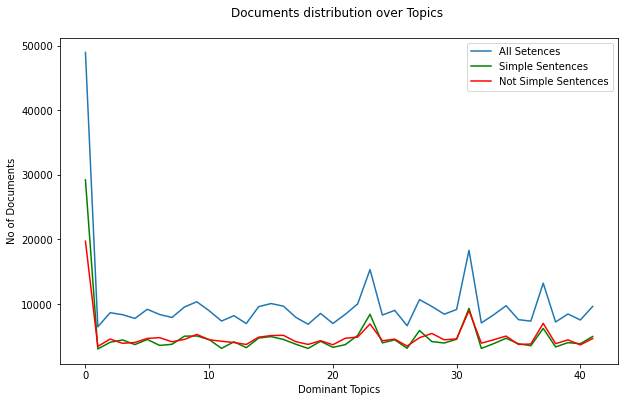

In [38]:
plt.figure(figsize=(10,6))

x = df_plot.Dominant_Topic
y1 = df_plot.Document_No
y2 = df_plot_simple.Document_No
y3 = df_plot_notsimple.Document_No

plt.plot(x, y1,label ='All Setences')
plt.plot(x, y2,'green',label ='Simple Sentences')
plt.plot(x, y3,'red',label ='Not Simple Sentences')

plt.xlabel('Dominant Topics')
plt.ylabel('No of Documents')
plt.legend()
plt.title('Documents distribution over Topics \n')
plt.show()


In [39]:
# df_plot = df_lda.sample(10000)
# print(len(df_plot))
# df_plot.head()

In [40]:
# import seaborn as sns

# plt.figure(figsize=(8,6))
# sca = sns.scatterplot(
#     data=df_plot,
#     x=df_plot.loc[:, 'Dominant_Topic'],
#     y=df_plot.loc[:, 'Perc_Contribution'],
#     hue=df_plot.loc[:, 'label'], # hue argument to specify grouping variable
# )
# plt.legend(loc='upper right')
# plt.title('Topics Contribution for '+str(len(df_plot))+ ' documents')

# plt.show()

In [41]:
# import plotly.express as px

In [42]:
# convert_dict = {'label': 'str'}

# df_plot = df_plot.astype(convert_dict)

# fig = px.scatter(df_plot,
#                  x="Dominant_Topic",
#                  y="Perc_Contribution",
#                  color=df_plot.label,
#                  hover_data=["Document_No"], #,"original_text_cleaned"],
#                  width=800, height=600,
#                  title ='Topics Contribution for '+str(len(df_plot))+ ' documents')
# fig.show()